# Web Crawling Implementation

This part of the code cotains the main web crawler implementation.

In [3]:
%pip install requests beautifulsoup4 pandas openpyxl matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Defining base URL
url = 'https://www.cnn.com'

# Using set to avoid duplicates
all_urls = set()

# Fetching main CNN page
data = requests.get(url).text

# Parsing HTML content
soup = BeautifulSoup(data, features="html.parser")

# Extract article URLs
for a in soup.find_all('a', href=True):
    href = a['href']
    # Avoiding irrelevant URLs
    if href and href.startswith('/') and not href.startswith(('//', '#', '/video', '/audio', '/gallery')) and '/gallery/' and '/video/' not in href:
        full_url = url + href
        all_urls.add(full_url)        
        # Stopping after 50 URLs
        if len(all_urls) >= 50:
            break

# Function to filter out ads
def is_article(url):
    # Exclude URLs with 'cnn-underscored' (ads)
    if 'cnn-underscored' in url:
        return False
    return True

# Function to handle None return values
def is_date(element):
    if element:
        return element.get_text()
    else:
        return None

# Function to extract and clean publication date
def extract_date(soup):
    pub_date = is_date(soup.find('div', {'class': 'timestamp'}))
    if pub_date:
        temp = pub_date.split()
        # Keeping only the last 3 tokens
        return " ".join(temp[-3:])
    return None

# Function to extract article summary
def extract_summary(soup):
    summary = soup.find('meta', {'name': 'description'})
    return summary.get('content') if summary else None

# Function to extract Titles, Dates, and Summaries
def extract_article_details(article_url):

    # Requesting and Parsing Data
    data2 = requests.get(article_url).text
    soup2 = BeautifulSoup(data2, features="html.parser")
    
    # Extracting Title
    title = soup2.find('h1') or soup2.find('title')
    title = title.get_text(strip=True) if title else None
    
    # Extracting Date
    pub_date = extract_date(soup2)
    if not pub_date:
        return None
    
    # Extracting Summary
    summary = extract_summary(soup2)
    if not summary:
        return None

    # Returning article details
    return {
        'Title': title,
        'Date': pub_date,
        'URL': article_url,
        'Summary': summary
    }

# List to store article data
article_data = []

# Collecting data from all URLs
for article_url in all_urls:
    if is_article(article_url):
        article_details = extract_article_details(article_url)
        # Skipping articles with missing info
        if article_details:
            article_data.append(article_details)
    # Displaying invalid URls (ads)
    else:
        print(f"Skipped URL: {article_url}\n")

Skipped URL: https://www.cnn.com/cnn-underscored/home/professional-lawn-garden-products

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-electric-toothbrush

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-beach-wagon

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-cooling-fans

Skipped URL: https://www.cnn.com/cnn-underscored/health-fitness/best-recovery-sandals-2025

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-hydrating-serums

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-hair-dryer

Skipped URL: https://www.cnn.com/cnn-underscored/home/products-under-50-to-upgrade-your-home

Skipped URL: https://www.cnn.com/cnn-underscored/fashion/best-travel-dresses

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-sandals-for-men

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-water-filter-pitchers

Skipped URL: https://www.cnn.com/cnn-underscored/reviews/best-camping-chairs

Skipped URL: http

# Topic Categorization

Implementing topic categorization using pre-trained spacy model.

In [6]:
%pip install spacy
!python -m spacy download en_core_web_md

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     --------------------------------------- 0.0/33.5 MB 435.7 kB/s eta 0:01:17
     --------------------------------------- 0.1/33.5 MB 653.6 kB/s eta 0:00:52
     ---------------------------------------- 0.3/33.5 MB 2.2 MB/s eta 0:00:16
     - -------------------------------------- 1.3/33.5 MB 6.9 MB/s eta 0:00:05
     ----- ---------------------------------- 4.2/33.5 MB 18.0 MB/s eta 0:00:02
     --------- ------------------------------ 7.6/33.5 MB 27.0 MB/s eta 0:00:01
     ------------- ------------------------- 11.9/33.5 MB 73.1 MB/s eta 0:00:01
     ----------------- --------------------- 15.3/33.5 MB 81.8 MB/s eta 0:00:01
     ---------------------- ---------------- 19.1/33.5 MB 81.8 MB/s eta 0:00:01
     --------------------------- ----------- 23.2/33.5 MB 81.8 MB/s eta 0:00:01
     ------------------------------- ------- 27.2/33.5 MB 81.8 M

In [16]:
# Imports
import spacy

# Creating dataframe from extracted data
df = pd.DataFrame(article_data)

# Loading spacy model
nlp = spacy.load("en_core_web_md")

# Defining categories with sample keywords for similarity comparison
category_keywords = {
    
    "Politics": ["election", "government", "president", "senate", "congress", "law", "political", "policy", "foreign", "prime minister"],
    "Science": ["research", "study", "scientist", "climate", "space", "biology", "physics", "chemistry"],
    "Technology": ["artificial intelligence", "software", "technology", "internet", "hardware", "cybersecurity"],
    "Health": ["covid", "vaccine", "health", "medical", "disease", "pandemic", "therapy", "medicine", "drug"],
    "Sports": ["cricket", "football", "soccer", "tennis", "olympics", "basketball", "athlete"],
    "Business": ["stocks", "economy", "market", "trade", "investment", "company", "finance"]
}

# Function to categorize articles using NLP
def categorize_using_nlp(title, summary):
    
    # Combining title and summary
    text = title + " " + summary  

    # Processing with spacy
    doc = nlp(text.lower())  

    # Default Category
    best_category = "Other"
    
    best_score = 0
    for category, keywords in category_keywords.items():

        # Converting category keywords to a single doc
        category_doc = nlp(" ".join(keywords)) 

        # Computing similarity score
        similarity = doc.similarity(category_doc)  

        # Comparing results
        if similarity > best_score:
            best_category = category
            best_score = similarity

    return best_category

# Function to categorize using URL structure
def categorize_using_url(url, current_category):
    # Only categorizes unclassified (Other)
    if current_category == "Other":
        for category in category_keywords.keys():
            if f"/{category.lower()}" in url.lower():
                return category
    return current_category

# Applying NLP-based categorization
df['Category'] = df.apply(lambda row: categorize_using_nlp(row['Title'], row['Summary']), axis=1)

# Applying URL-based categorization if necessary
df['Category'] = df.apply(lambda row: categorize_using_url(row['URL'], row['Category']), axis=1)

# Saving to the Excel File
# df.to_excel(file, index=False)
# print(f"\nCategorized data saved to {file}")

# Function to display categorized articles
def display_articles_by_category(category):
    results = df[df['Category'].str.lower() == category.lower()]    
    if results.empty:
        print(f"\nNo articles found for category: {category}")
    else:
        print(f"\nArticles in category '{category}':\n")
        for _, row in results.iterrows():
            print(f"Title: {row['Title']}")
            print(f"Publication Date: {row['Date']}")
            print(f"Summary: {row['Summary']}")
            print(f"URL: {row['URL']}\n")

After running the cell below enter a category to get revelant articles.

In [19]:
# Asking user for input
user_category = input("\nEnter a category to view articles (Politics, Science, Technology, Health, Sports, Business, Other): ")
display_articles_by_category(user_category)


Enter a category to view articles (Politics, Science, Technology, Health, Sports, Business, Other):  Politics



Articles in category 'Politics':

Title: India-Pakistan ceasefire raises hopes that the worst fighting in decades is over. Here’s what to know
Publication Date: May 11, 2025
Summary: A ceasefire agreed between India and Pakistan appears to be holding, with both sides stressing their commitment to the surprise truce which halted the worst fighting in decades between the nuclear-armed neighbors.
URL: https://www.cnn.com/2025/05/10/asia/india-pakistan-ceasefire-explainer-latam-intl

Title: Rising waters and overtourism are killing Venice. Now the fight is on to save its soul
Publication Date: May 10, 2025
Summary: Venice isn’t just dealing with too many visitors. It also has major issues from depopulation, and rising sea levels. But some locals won’t stop trying to change things for the better as they battle to save Venice from going under.
URL: https://www.cnn.com/travel/battle-for-the-soul-of-venice

Title: ‘Never again war!’ Pope Leo calls for peace in Ukraine and Gaza in first Vatica

# Data Visualization

Below we have two graphs:
- Bar chart showing the distribution of topics.
- Line graph tracking the number of articles published overtime.

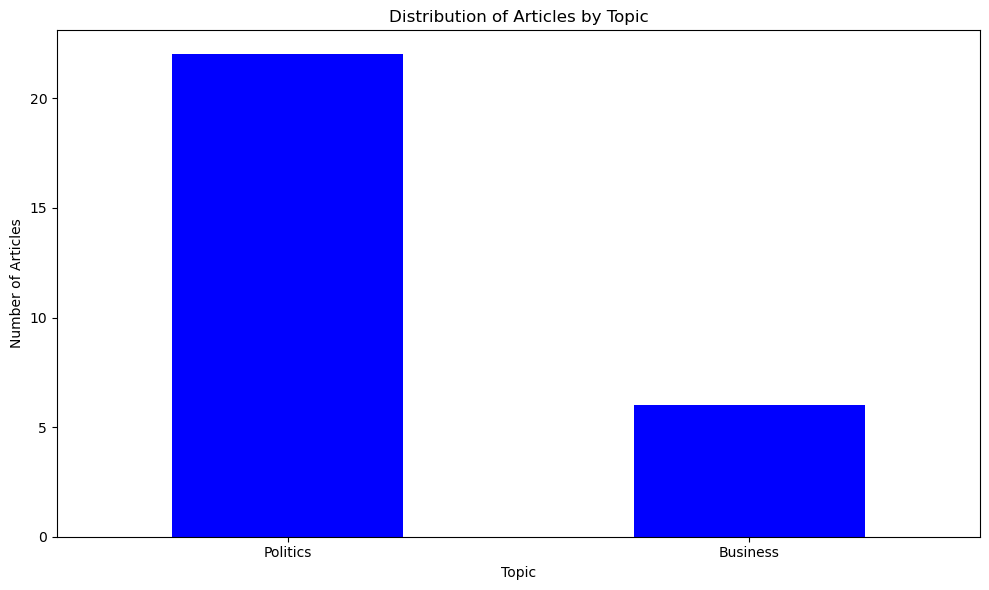

In [22]:
# Imports
import matplotlib.pyplot as plt

# Displaying bar chart 
topic_count = df['Category'].value_counts()
plt.figure(figsize=(10, 6))
topic_count.plot(kind='bar', color='blue')
plt.title('Distribution of Articles by Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

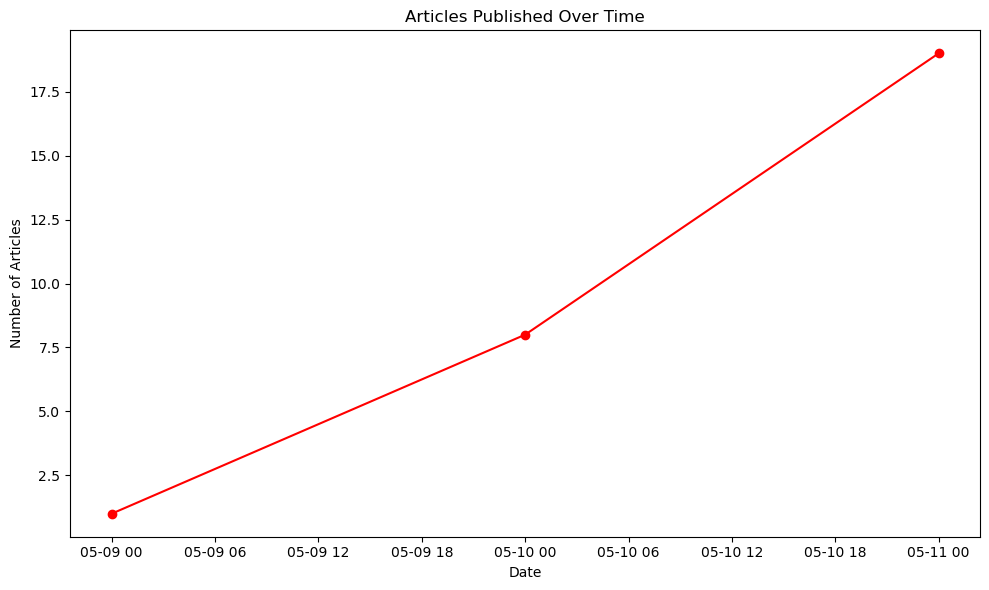

In [24]:
# Displaying line graph
df['Publication Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date
articles_by_date = df.groupby(df['Publication Date']).size()
plt.figure(figsize=(10, 6))
articles_by_date.plot(kind='line', marker='o', color='red')
plt.title('Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

# Dropping 'Publication Date' column after plotting
df.drop('Publication Date', axis=1, inplace=True)

# Generating Summaries

Next, we generated our own summaries using spacy by going through all the text in an article and picking the best 3 lines which gave us the most relevant information about the article.

In [27]:
%pip install newspaper3k lxml_html_clean pydantic
!pip install --upgrade pydantic

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/66.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/66.6 kB ? eta -:--:--
     ----------------------- -------------- 41.0/66.6 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 66.6/66.6 kB 599.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/443.9 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/443.9 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------  440.3/443.9 kB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 443.9/443.9 kB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ----------------------- ---------------- 1.1/2.0 MB 36.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.23.4
    

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-ibm-runtime 0.35.0 requires pydantic<2.10,>=2.5.0, but you have pydantic 2.11.4 which is incompatible.


In [30]:
# Imports
from newspaper import Article
import time

# Loading spacy model
nlp = spacy.load("en_core_web_md")

# Function to get article text
def fetch_article(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""

# Function to get most informative sentences
def summarize_article(text, num_sentences=3):
    
    doc = nlp(text)
    sentences = list(doc.sents)

    # Scoring sentences based on named entities & nouns
    sentence_scores = {}
    for sent in sentences:
        score = sum(1 for token in sent if token.ent_type_ or token.pos_ in ["NOUN", "PROPN"])
        sentence_scores[sent] = score

    # Selecting top 3 sentences with the highest scores
    ranked_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)
    summary = " ".join(str(sentence) for sentence in ranked_sentences[:num_sentences])
    
    return summary.strip()

# Extracting and summarizing articles
summaries = []
for url in df['URL']:
    print(f"Processing: {url}")
    article_text = fetch_article(url)    
    if article_text:
        summary = summarize_article(article_text)
    else:
        summary = "Could not retrieve article."

    # Adding generated summary to the list
    summaries.append(summary)

# Add summaries to the dataframe
df["Generated Summary"] = summaries

# Removing '\n' from the generated summaries
df["Generated Summary"] = df["Generated Summary"].str.replace("\n", "", regex=True)

# Saving to the Excel File
file = 'articles.xlsx'
df.to_excel(file, index=False)
print(f"\nData saved to {file}")

Processing: https://www.cnn.com/2025/05/10/asia/india-pakistan-ceasefire-explainer-latam-intl
Processing: https://www.cnn.com/travel/battle-for-the-soul-of-venice
Processing: https://www.cnn.com/2025/05/11/us/newark-airport-outage-dg
Processing: https://www.cnn.com/2025/05/11/europe/pope-leo-vatican-balcony-prayer-intl
Processing: https://www.cnn.com/2025/05/10/europe/putin-russia-ukraine-direct-talks-intl-hnk
Processing: https://www.cnn.com/2025/05/10/entertainment/sean-diddy-combs-timeline-trial
Processing: https://www.cnn.com/2025/05/11/middleeast/trump-visit-gulf-arab-states-saudi-uae-qatar-intl
Processing: https://www.cnn.com/2025/05/11/politics/ice-facility-democrats-arrest-newark-mayor-baraka
Processing: https://www.cnn.com/2025/05/10/sport/trendlines-nba-playoff-ticket-prices-spt
Processing: https://www.cnn.com/2025/05/11/politics/pregnant-mothers-supreme-courts-birthright-citizenship
Processing: https://www.cnn.com/2025/05/10/europe/pope-leo-prevost-cardinals-artificial-intell